# Урок 5. Кейс 1. Аномалии и артефакты

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. Сделайте ее перерасчет (ресемплинг) в представление по неделям.
4. Постройте модель предсказания 1-й точки от текущей (h=1).
5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [1]:
import numpy as np
import pandas as pd 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

**1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями**

In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.rename(columns={'Значение': 'brent_price'}, inplace=True)
brent_data.head()

,brent_price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
brent_data.describe()

,brent_price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


In [4]:
d_brent_data = brent_data['brent_price'].values[1:] - brent_data['brent_price'].values[:-1]
s_brent = np.std(d_brent_data)**0.5 *3
anomal_brent_price_ind = np.where(abs(d_brent_data) > s_brent)[0]

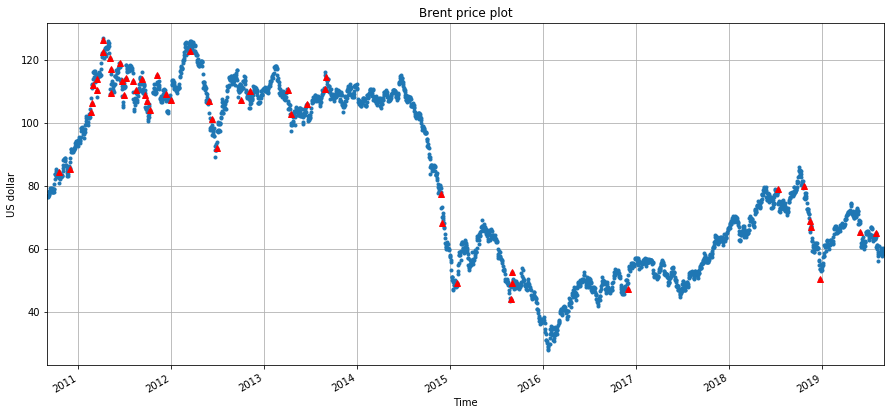

In [5]:
_ = brent_data['brent_price'].plot(style='.', figsize=(15, 7), title='Brent price plot')
plt.plot(brent_data.iloc[anomal_brent_price_ind].index, brent_data['brent_price'].values[anomal_brent_price_ind],'^r', label='Brent anomaly')
plt.grid()
plt.xlabel('Time')
plt.ylabel('US dollar');

In [6]:
brent_data['brent_diff'] = brent_data['brent_price'].diff().fillna(0)
brent_data.head()

,brent_price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,brent_diff
Дата,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01


**2. Добавьте первые разности по стоимости доллара и евро к рублю**

In [7]:
rub_USD=pd.read_excel('D_F01_09_2010_T01_09_2019.xlsx')
rub_USD.index = pd.to_datetime(rub_USD['data'].values).date
rub_USD.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_USD.rename(columns={'curs': 'usd_curs'}, inplace=True)
rub_USD.head()

,usd_curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [8]:
rub_USD.describe()

,usd_curs
count,2228.000000
mean,48.129075
std,15.849952
min,27.262500
25%,31.544075
50%,54.585650
75%,63.501375
max,83.591300


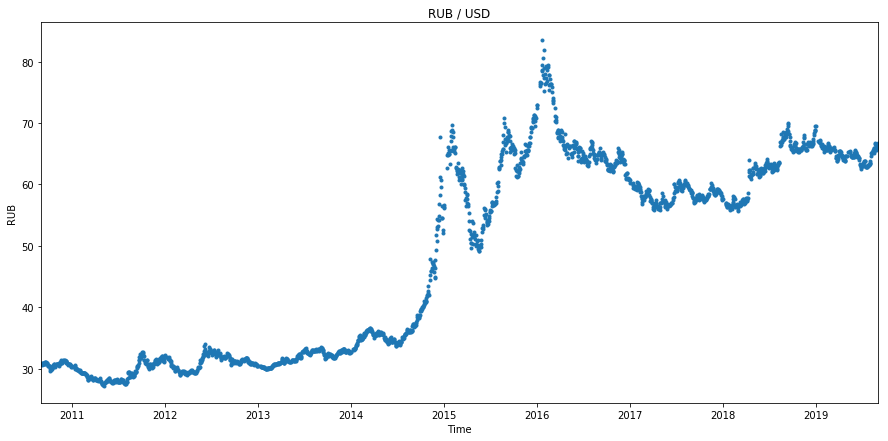

In [9]:
_ = rub_USD['usd_curs'].plot(style='.', figsize=(15, 7), title='RUB / USD')
plt.ylabel('RUB')
plt.xlabel('Time');

In [10]:
rub_USD['usd_curs_diff'] = rub_USD['usd_curs'].diff().fillna(0)
rub_USD.head()

,usd_curs,usd_curs_diff
2010-09-01,30.8669,0.0000
2010-09-02,30.8001,-0.0668
2010-09-03,30.6858,-0.1143
2010-09-04,30.6922,0.0064
2010-09-07,30.5771,-0.1151


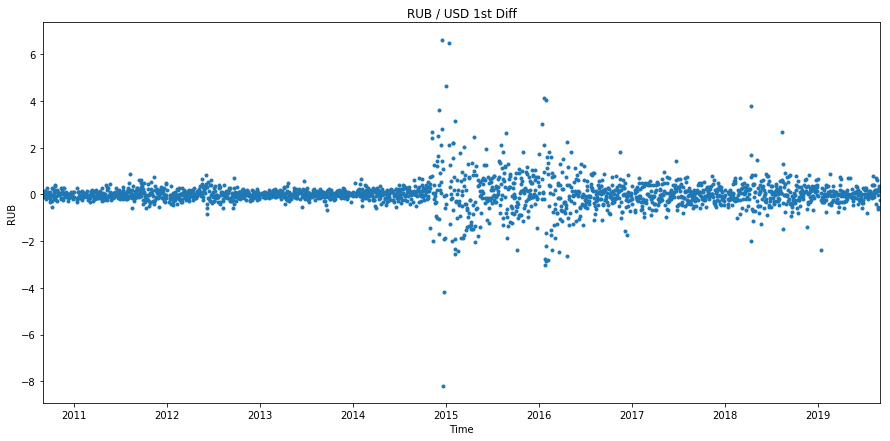

In [11]:
_ = rub_USD.iloc[1:, -1].plot(style='.', figsize=(15, 7), title='RUB / USD 1st Diff')
plt.ylabel('RUB')
plt.xlabel('Time');

In [12]:
rub_EUR = pd.read_excel('E_F01_09_2010_T01_09_2019.xlsx')
rub_EUR.index = pd.to_datetime(rub_EUR['data'].values).date
rub_EUR.drop(['nominal','cdx','data'], axis=1, inplace = True)
rub_EUR.rename(columns={'curs': 'eur_curs'}, inplace=True)
rub_EUR.head()

,eur_curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [13]:
rub_EUR.describe()

,eur_curs
count,2228.000000
mean,57.575975
std,14.888395
min,38.411700
25%,41.506800
50%,60.647850
75%,71.823025
max,91.181400


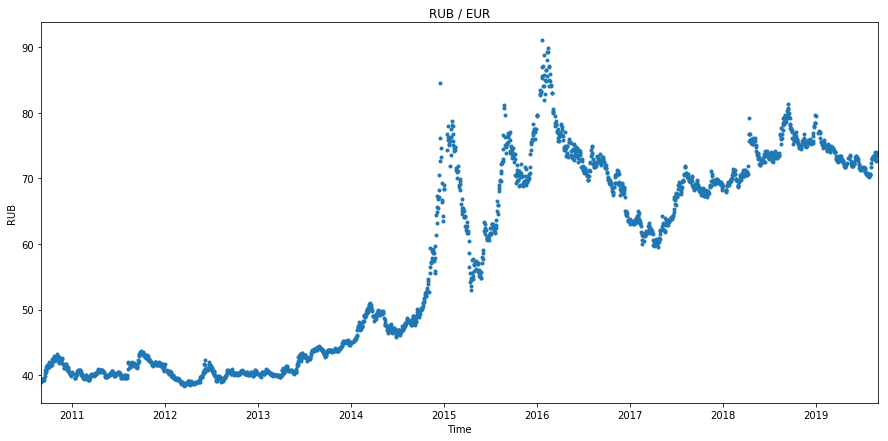

In [14]:
_ = rub_EUR['eur_curs'].plot(style='.', figsize=(15, 7), title='RUB / EUR')
plt.ylabel('RUB')
plt.xlabel('Time');

In [15]:
rub_EUR['eur_curs_diff'] = rub_EUR['eur_curs'].diff().fillna(0)
rub_EUR.head()

,eur_curs,eur_curs_diff
2010-09-01,39.0127,0.0000
2010-09-02,39.1654,0.1527
2010-09-03,39.2901,0.1247
2010-09-04,39.3505,0.0604
2010-09-07,39.4720,0.1215


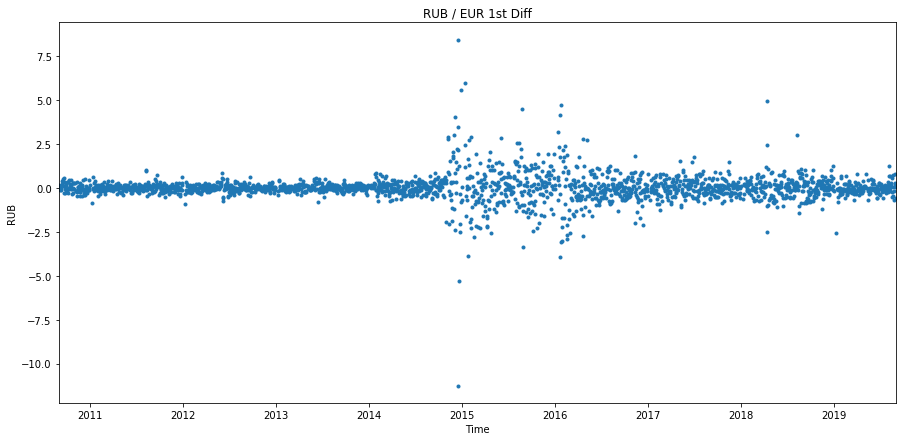

In [16]:
_ = rub_EUR.iloc[1:, -1].plot(style='.', figsize=(15, 7), title='RUB / EUR 1st Diff')
plt.ylabel('RUB')
plt.xlabel('Time');

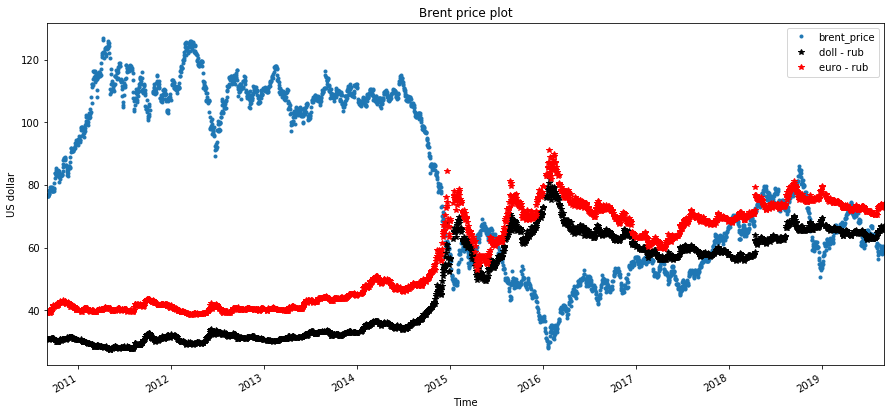

In [17]:
_ = brent_data['brent_price'].plot( style='.', figsize=( 15, 7 ), title='Brent price plot')
plt.plot(rub_USD.index,rub_USD['usd_curs'].values,'*k', label='doll - rub')
plt.plot(rub_EUR.index,rub_EUR['eur_curs'].values,'*r', label='euro - rub')
plt.ylabel('US dollar')
plt.xlabel('Time')
plt.legend();

**3. Сделайте ее перерасчет (ресемплинг) в представление по неделям.**

In [18]:
brent_data['brent_diff'] = 0
brent_data['brent_diff'] = brent_data['brent_diff'].astype('float')
brent_data['brent_diff'].values[1:] = d_brent_data

In [19]:
temp_df = pd.merge(brent_data, rub_USD, how='inner', left_index=True, right_index=True)
temp_df = pd.merge(temp_df, rub_EUR, how='inner', left_index=True, right_index=True)
temp_df = temp_df.drop(['usd_curs', 'eur_curs', 'dayofmonth', 'dayofyear', 'dayofweek',  'is_prev_holiday', 
             'is_next_holiday', 'year','month','quarter','weekofyear','is_holiday'], axis=1)

In [20]:
brent_W = temp_df.resample("W").mean()
brent_W = brent_W.dropna()
brent_W.head()

,brent_price,brent_diff,usd_curs_diff,eur_curs_diff
2010-09-05,76.6125,0.0625,-0.043675,0.084450
2010-09-12,77.8340,0.2980,0.040300,-0.031760
2010-09-19,78.6850,-0.3050,0.032150,0.281225
2010-09-26,78.2025,-0.1400,-0.019875,0.181625
2010-10-03,81.3600,1.4175,-0.108850,0.044825


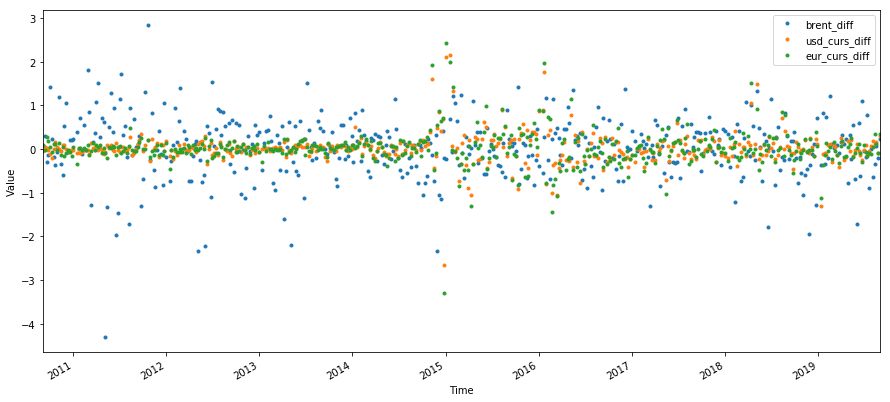

In [21]:
_ = brent_W['brent_diff'].plot(style='.', figsize=(15, 7))
_ = brent_W['usd_curs_diff'].plot(style='.', figsize=(15, 7))
_ = brent_W['eur_curs_diff'].plot(style='.', figsize=(15, 7))
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend();

In [22]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [23]:
brent_W['brent_diff_exp_0_01'] = exponential_smoothing(brent_W['brent_diff'], 0.01)
brent_W['brent_diff_exp_0_07'] = exponential_smoothing(brent_W['brent_diff'], 0.07)
brent_W['brent_diff_exp_0_10'] = exponential_smoothing(brent_W['brent_diff'], 0.10)

brent_W['usd_curs_diff_exp_0_01'] = exponential_smoothing(brent_W['usd_curs_diff'], 0.01)
brent_W['usd_curs_diff_exp_0_07'] = exponential_smoothing(brent_W['usd_curs_diff'], 0.07)
brent_W['usd_curs_diff_exp_0_10'] = exponential_smoothing(brent_W['usd_curs_diff'], 0.10)

brent_W['eur_curs_diff_exp_0_01'] = exponential_smoothing(brent_W['eur_curs_diff'], 0.01)
brent_W['eur_curs_difff_exp_0_07'] = exponential_smoothing(brent_W['eur_curs_diff'], 0.07)
brent_W['eur_curs_diff_exp_0_10'] = exponential_smoothing(brent_W['eur_curs_diff'], 0.10)

brent_W.head()

,brent_price,brent_diff,usd_curs_diff,eur_curs_diff,brent_diff_exp_0_01,brent_diff_exp_0_07,brent_diff_exp_0_10,usd_curs_diff_exp_0_01,usd_curs_diff_exp_0_07,usd_curs_diff_exp_0_10,eur_curs_diff_exp_0_01,eur_curs_difff_exp_0_07,eur_curs_diff_exp_0_10
2010-09-05,76.6125,0.0625,-0.043675,0.084450,0.062500,0.062500,0.062500,-0.043675,-0.043675,-0.043675,0.084450,0.084450,0.084450
2010-09-12,77.8340,0.2980,0.040300,-0.031760,0.064855,0.078985,0.086050,-0.042835,-0.037797,-0.035278,0.083288,0.076315,0.072829
2010-09-19,78.6850,-0.3050,0.032150,0.281225,0.061156,0.052106,0.046945,-0.042085,-0.032900,-0.028535,0.085267,0.090659,0.093669
2010-09-26,78.2025,-0.1400,-0.019875,0.181625,0.059145,0.038659,0.028250,-0.041863,-0.031989,-0.027669,0.086231,0.097027,0.102464
2010-10-03,81.3600,1.4175,-0.108850,0.044825,0.072728,0.135178,0.167175,-0.042533,-0.037369,-0.035787,0.085817,0.093372,0.096700


**4. Постройте модель предсказания 1-й точки от текущей (h=1).**

In [24]:
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

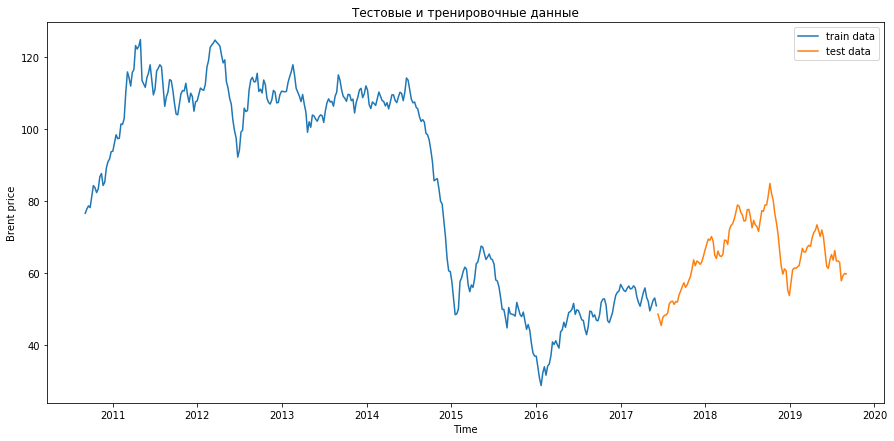

In [25]:
# Определим долю тестовой выборки как 0.25
train, test = split_data(brent_W[-2000:], -int(brent_W.shape[0]*0.25))

plt.figure(figsize=(15, 7))
plt.xlabel('Time')
plt.ylabel('Brent price')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')

plt.title('Тестовые и тренировочные данные')
plt.legend();

In [26]:
h = 1

X_train = train.iloc[:-h,:]
y_train = train['brent_diff'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['brent_diff'].values[h:]

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
model_cat = GradientBoostingRegressor(max_depth=9, random_state=21, n_estimators=750)

In [29]:
model_cat.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=9,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=750,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

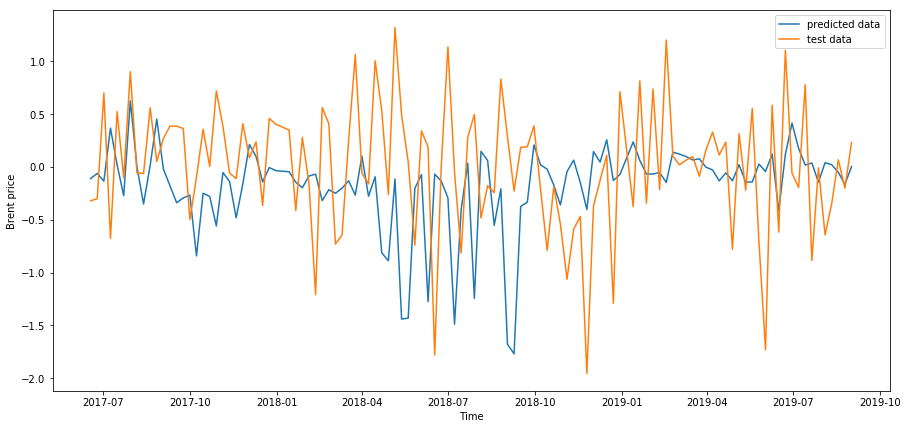

In [30]:
y_test_pred_c = model_cat.predict(X_test)

plt.figure( figsize=( 15, 7 ))

plt.xlabel('Time')
plt.ylabel('Brent price')
plt.plot(test.index[h:],y_test_pred_c, label='predicted data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend();

In [31]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_c) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_c) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_c)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

er_g = mean_absolute_percentage_error(y_test, y_test_pred_c)

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка mse :   0.5701312076845888 
ошибка mae  :   0.5861704281400859 
оценка R2 :   -0.590525678608081
ошибка градиентного бустинга MAPE :   280.5962588695462 %


**5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.**

Модель предсказания на один шаг вперед (h=1) выдает очень плохой результат.